<a href="https://colab.research.google.com/github/dvircohen0/GAN/blob/main/CGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**imports**

In [ ]:
from __future__ import print_function
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from torchvision.utils import save_image

**Set the hyperparameters**

In [ ]:
# Root folser for the dataset
dataroot = "/content"
# Number of workers for the dataloader
workers = 2
# batch size during the training
batch_size = 64
# all the images will be resize to this size
image_size = 32
# number of channels
nc = 1
# size of the latent vector
nz = 100
# size of feature map in the generator
ngf = 64
# size of feature map in the Discriminator
ndf = 64
# number of training epochs
num_epochs = 5
# learning rate for the optimizers
lr = 0.0002
# beta1 rate for Adam optimizer
beta1 = 0.5
# number of GPU avialbel
ngpu = 8
# number of classes in the datase
n_classes = 10
# the interval between image sampling
sample_interval = 400

**Loading the dataset**

In [ ]:
os.makedirs("images", exist_ok = True)
os.makedirs(dataroot, exist_ok = True)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dset.FashionMNIST(dataroot,train = True,download = True,
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),transforms.Normalize([0.5], [0.5])]),),
    batch_size = batch_size,shuffle = True,)
dataloaderC = torch.utils.data.DataLoader(dataloader, batch_size = batch_size, shuffle = True, num_workers = workers)

# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**build the generator and discriminator models**

In [ ]:
# weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
image_shape = (nc, image_size, image_size)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(nz + n_classes, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh())
        
    # concatenate label embedding and image to produce input   
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *image_shape)
        return img
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 1),)
        
    def forward(self, img, labels):

       # concatenate label embedding and image to produce input  
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# create the generator    
netG = Generator().to(device)

# initialize weights  
netG.apply(weights_init)
print(netG)

# create the discriminator    
netD = Discriminator().to(device)

# initialize weights
netD.apply(weights_init)
print(netD)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=1034, out_fea

**Define the loss function and the optimizers**

In [ ]:
#initialize MELoss finction
loss = nn.MSELoss()
real_label = 1
fake_label = 0
 
 #set Adam optimizer for G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

FloatTensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor

**Generate images using the generator**

In [ ]:
def sample_image(n_row, batches_done):

    # sample noise
    z = Variable(FloatTensor(np.random.normal(0,1,(n_row**2,nz))))

    # get labels ranging from 0 to n_classes
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imags = netG(z, labels)
    save_image(gen_imags.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

**Train the model**

In [ ]:
#------------------------
#    Training 
#------------------------    
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]
        
        # Adversial ground truths
        valid = Variable(FloatTensor(batch_size,1).fill_(1.0), requires_grad = False)
        fake = Variable(FloatTensor(batch_size,1).fill_(0.0), requires_grad = False)
        
        # configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        
        #------------------------
        #    Train Generator
        #------------------------
        
        optimizerG.zero_grad()

        # sample noise and labels as input
        z = Variable(FloatTensor(np.random.normal(0,1,(batch_size,nz))))
        gen_labels = Variable(LongTensor(np.random.randint(0,n_classes, batch_size)))

        # generate a batch of images
        gen_imgs = netG(z, gen_labels)

        # the loss mesures the ablility of the generator to fool the discriminator
        validity = netD(gen_imgs, gen_labels)
        g_loss = loss(validity, valid)
        g_loss.backward()
        optimizerG.step()
        
         #------------------------
        #    Train Discriminator
        #------------------------

        optimizerD.zero_grad()

        #loss for real images
        validity_real = netD(real_imgs, labels)
        d_real_loss = loss(validity_real, valid)

         #loss for fake images
        validity_fake = netD(gen_imgs.detach(), labels)
        d_fake_loss = loss(validity_fake, fake)

        # totla discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizerD.step()

        print("[Epoch %d/%d][Batch %d/%d][D loss %f][G loss %f]"%
              (epoch, num_epochs, i , len(dataloader), d_loss.item(), g_loss.item()))
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

**Display the generated images**

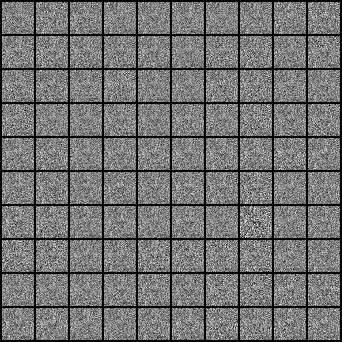

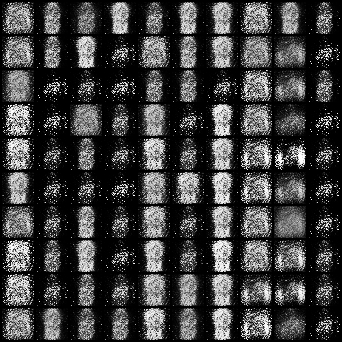

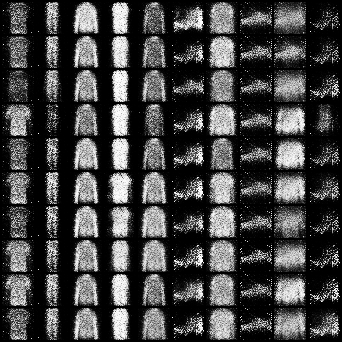

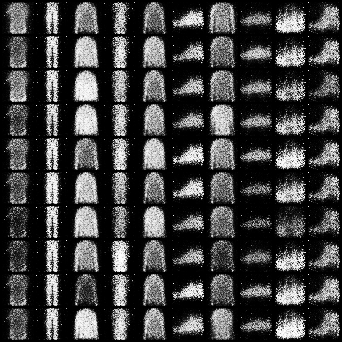

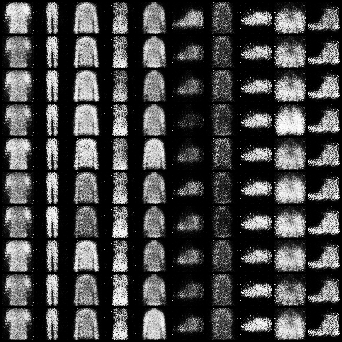

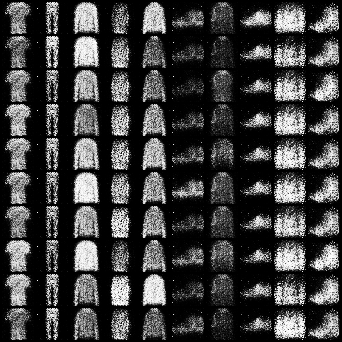

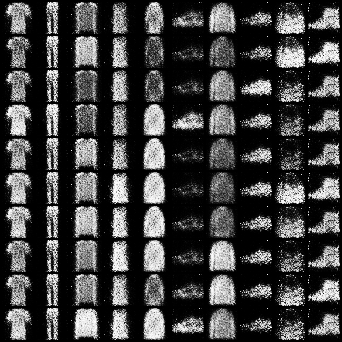

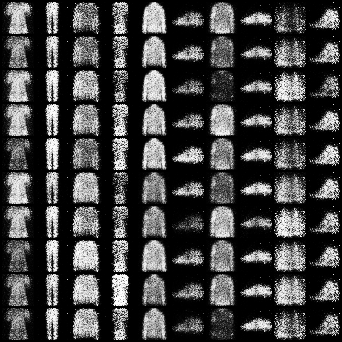

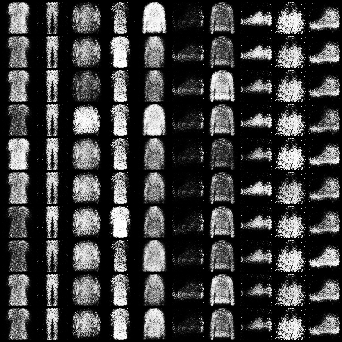

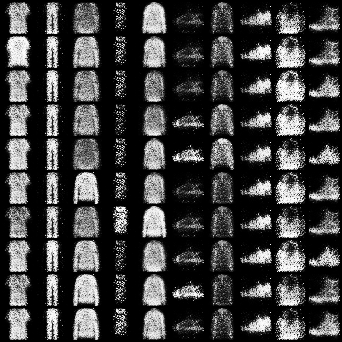

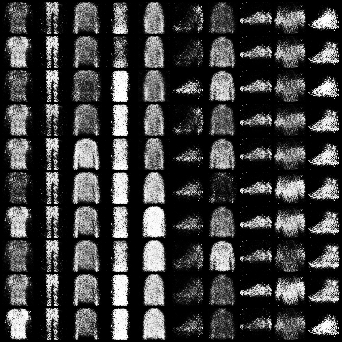

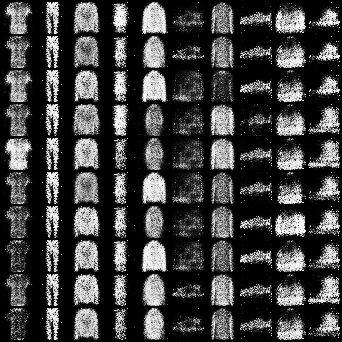

In [ ]:
from PIL import Image
from IPython.display import Image 
import re
import glob

frames=[]
imgs = glob.glob("/content/images/*.png")
imgs.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
for i in imgs:
  pil_img = Image(filename=i)
  display(pil_img)
